In [1]:
pip install requests pandas networkx plotly nbformat python-louvain



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade nbformat


[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations
from collections import Counter
import networkx as nx
import community.community_louvain as community


In [4]:
response = requests.get("https://api.openalex.org/concepts?search=artificial intelligence")
print(response.json())

{'meta': {'count': 30, 'db_response_time_ms': 53, 'page': 1, 'per_page': 25, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/C154945302', 'wikidata': 'https://www.wikidata.org/wiki/Q11660', 'display_name': 'Artificial intelligence', 'relevance_score': 652325.4, 'level': 1, 'description': 'field of computer science and engineering practices for intelligence demonstrated by machines and intelligent agents', 'works_count': 16067783, 'cited_by_count': 227657854, 'summary_stats': {'2yr_mean_citedness': 2.2172339527216707, 'h_index': 2910, 'i10_index': 3354327}, 'ids': {'openalex': 'https://openalex.org/C154945302', 'wikidata': 'https://www.wikidata.org/wiki/Q11660', 'mag': '154945302', 'wikipedia': 'https://en.wikipedia.org/wiki/Artificial%20intelligence', 'umls_cui': ['C0003916']}, 'image_url': None, 'image_thumbnail_url': None, 'international': {'display_name': {'af': 'Kunsmatige intelligensie', 'am': 'ሠው ሰራሽ ዕውቀት', 'an': 'Intelichencia artificial', 'ar': 'ذكاء اصطناعي', '

In [5]:
url = "https://api.openalex.org/works"
params = {
    'filter': 'concepts.id:C154945302',
    'per-page': 200
}

response = requests.get(url, params=params)
data = response.json()

In [6]:
print(response.status_code)
print(data) #print

200
{'meta': {'count': 15579600, 'db_response_time_ms': 619, 'page': 1, 'per_page': 200, 'groups_count': None}, 'results': [{'id': 'https://openalex.org/W2194775991', 'doi': 'https://doi.org/10.1109/cvpr.2016.90', 'title': 'Deep Residual Learning for Image Recognition', 'display_name': 'Deep Residual Learning for Image Recognition', 'publication_year': 2016, 'publication_date': '2016-06-01', 'ids': {'openalex': 'https://openalex.org/W2194775991', 'doi': 'https://doi.org/10.1109/cvpr.2016.90', 'mag': '2194775991'}, 'language': 'en', 'primary_location': {'is_oa': False, 'landing_page_url': 'https://doi.org/10.1109/cvpr.2016.90', 'pdf_url': None, 'source': None, 'license': None, 'license_id': None, 'version': None, 'is_accepted': False, 'is_published': False}, 'type': 'article', 'type_crossref': 'proceedings-article', 'indexed_in': ['crossref'], 'open_access': {'is_oa': True, 'oa_status': 'green', 'oa_url': 'https://repositorio.unal.edu.co/bitstream/unal/81443/1/98670607.2022.pdf', 'any_r

In [7]:
#Get the information (Authors, Institutions, Countries, Citations)
works = data['results']

records = []
for work in works:
    title = work.get('title', 'N/A')
    citations = work.get('cited_by_count', 0)
    
    authors = []
    institutions = []
    countries = []
    
    for author in work.get('authorships', []):
        author_name = author['author']['display_name']
        authors.append(author_name)
        
        if 'institutions' in author and author['institutions']:
            for inst in author['institutions']:
                institutions.append(inst.get('display_name', 'Unknown'))
                country = inst.get('country_code', 'N/A')
                if country is None:
                    country = 'N/A'
                countries.append(country)
        else:
            institutions.append('N/A')
            countries.append('N/A')
    
    records.append({
        'Title': title,
        'Authors': ', '.join(authors),
        'Institutions': ', '.join(institutions),
        'Countries': ', '.join(countries),
        'Citations': citations
    })

df = pd.DataFrame(records)


In [8]:
#explore
print(df.info()) 
print(df.describe())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         196 non-null    object
 1   Authors       200 non-null    object
 2   Institutions  200 non-null    object
 3   Countries     200 non-null    object
 4   Citations     200 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 7.9+ KB
None
           Citations
count     200.000000
mean    29278.350000
std     18516.141845
min     16094.000000
25%     18619.250000
50%     22719.500000
75%     34006.750000
max    181766.000000


In [9]:
print("Unique Articles:", df['Title'].nunique())
print("Unique Authors:", df['Authors'].str.split(', ').explode().nunique())
print("Unique Countries:", df['Countries'].str.split(', ').explode().nunique())

#unique institutions
print("Unique Institutions:", df['Institutions'].str.split(', ').explode().nunique())


Unique Articles: 189
Unique Authors: 529
Unique Countries: 25
Unique Institutions: 192


In [10]:
top_authors = df['Authors'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Authors:\n", top_authors)

top_institutions = df['Institutions'].str.split(', ').explode().value_counts().head(10)
print("Top 10 Institutions:\n", top_institutions)


Top 10 Authors:
 Authors
Geoffrey E. Hinton    8
Ross Girshick         7
Kaiming He            6
Yoshua Bengio         4
Alex Krizhevsky       4
Trevor Hastie         4
Jerome H. Friedman    4
Piotr Dollár          4
Andrew Zisserman      4
Christian Szegedy     4
Name: count, dtype: int64
Top 10 Institutions:
 Institutions
N/A                                                   108
Google (United States)                                 54
DeepMind (United Kingdom)                              33
University of California                               29
European Centre for Medium-Range Weather Forecasts     28
Stanford University                                    27
Berkeley                                               17
Meta (Israel)                                          16
Berkeley College                                       12
University of Toronto                                  12
Name: count, dtype: int64


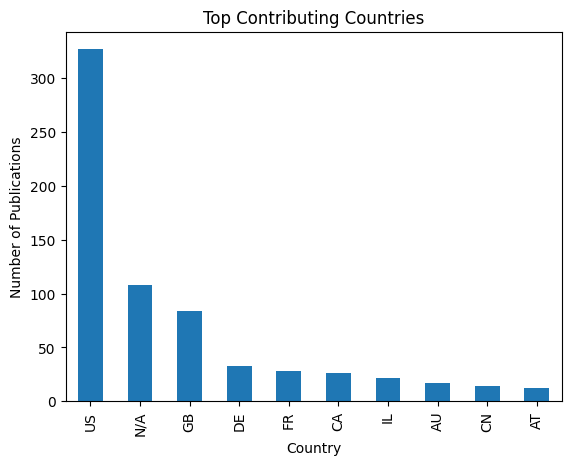

In [11]:
#countries
top_countries = df['Countries'].str.split(', ').explode().value_counts().head(10)
top_countries.plot(kind='bar')
plt.title("Top Contributing Countries")
plt.xlabel("Country")
plt.ylabel("Number of Publications")
plt.show()


In [12]:
#make the pairs
country_pairs = []
for countries in df['Countries']:
    country_list = list(set(countries.split(', ')))
    country_pairs += list(combinations(country_list, 2))

pair_counts = Counter(country_pairs)
top_pairs = dict(sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top Country Collaborations:\n", top_pairs)


Top Country Collaborations:
 {('N/A', 'US'): 13, ('US', 'CA'): 4, ('N/A', 'CA'): 4, ('GB', 'US'): 4, ('JP', 'US'): 3, ('DE', 'US'): 3, ('CN', 'US'): 3, ('US', 'IL'): 3, ('JP', 'DE'): 2, ('US', 'FR'): 2}


In [13]:
#citations
df.groupby('Authors')['Citations'].sum().sort_values(ascending=False).head(10)


Authors
Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun                                                                           198721
Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton                                                                         100020
Leo Breiman                                                                                                                  99258
Yoav Benjamini, Yosef Hochberg                                                                                               94882
Karen Simonyan, Andrew Zisserman                                                                                             88884
Stephen F. Altschul, Warren Gish, Webb Miller, Eugene W. Myers, David J. Lipman                                              87570
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Łukasz Kaiser, Illia Polosukhin     75884
                                                                           

In [14]:
#double check for empty data. does this get rid of the N/As? 
if df.empty:
    print("No data to analyze.")
else:
    print(df.head())


                                               Title  \
0       Deep Residual Learning for Image Recognition   
1                                               None   
2  Controlling the False Discovery Rate: A Practi...   
3                  Basic local alignment search tool   
4  Gapped BLAST and PSI-BLAST: a new generation o...   

                                             Authors  \
0  Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun   
1                                        Leo Breiman   
2                     Yoav Benjamini, Yosef Hochberg   
3  Stephen F. Altschul, Warren Gish, Webb Miller,...   
4                                Stephen F. Altschul   

                                        Institutions  \
0  Microsoft Research (United Kingdom), Microsoft...   
1                 University of California, Berkeley   
2           Tel Aviv University, Tel Aviv University   
3  National Center for Biotechnology Information,...   
4  National Center for Biotechnology Informati

In [15]:
#start with nx
G = nx.Graph()

#create edges
for index, row in df.iterrows():
    authors = row['Authors'].split(', ')
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            if G.has_edge(authors[i], authors[j]):
                G[authors[i]][authors[j]]['weight'] += 1  #maybe do a weight for repeated collaborations
            else:
                G.add_edge(authors[i], authors[j], weight=1)


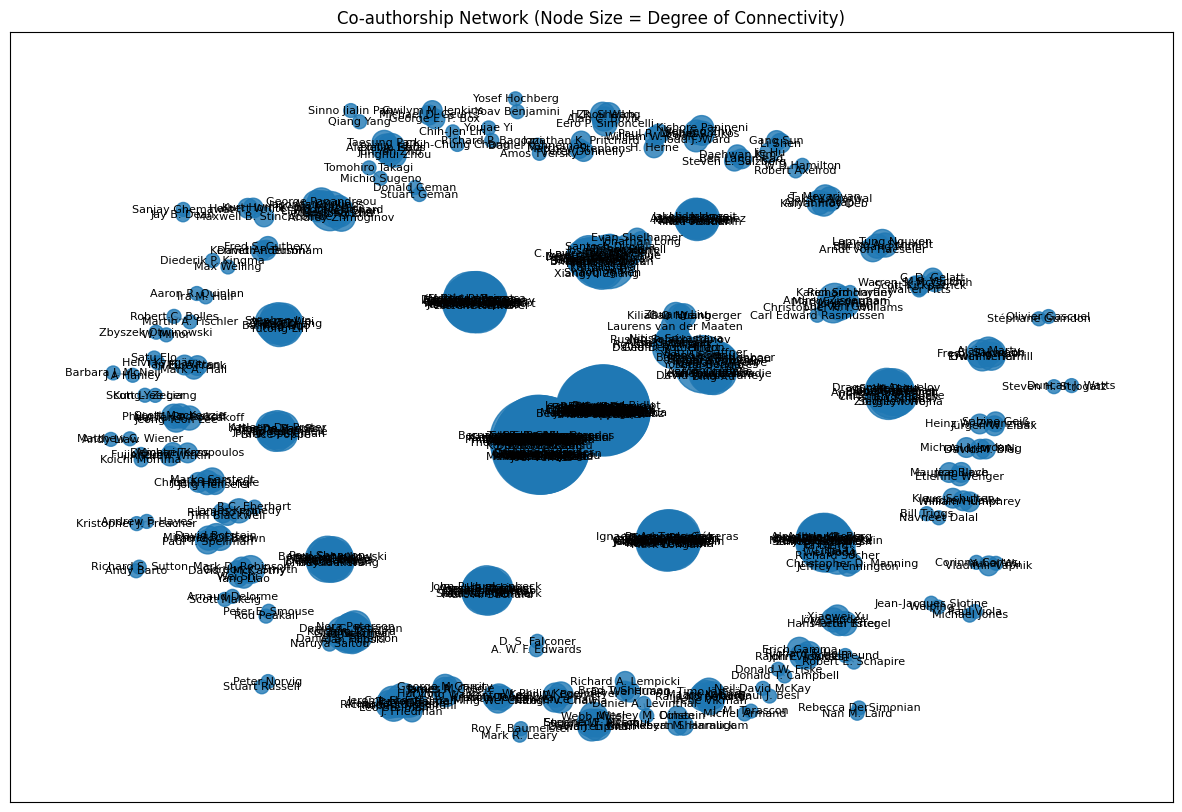

In [16]:
degree = dict(G.degree())
node_size = [v * 100 for v in degree.values()]  #nodes are too small need them larger

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)

#draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_size, alpha=0.8)

#draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

#draw labels with reduced overlap
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Co-authorship Network (Node Size = Degree of Connectivity)")
plt.show()


Number of Nodes (Authors): 480
Number of Edges (Collaborations): 2311
Top 10 Authors by Degree Centrality:
Stig Petersen: 0.10
David Silver: 0.10
Koray Kavukcuoglu: 0.10
Demis Hassabis: 0.10
Olaf Ronneberger: 0.07
Dick Dee: 0.07
S. Uppala: 0.07
A. J. Simmons: 0.07
Paul Berrisford: 0.07
Paul Poli: 0.07
Number of Communities Detected: 89


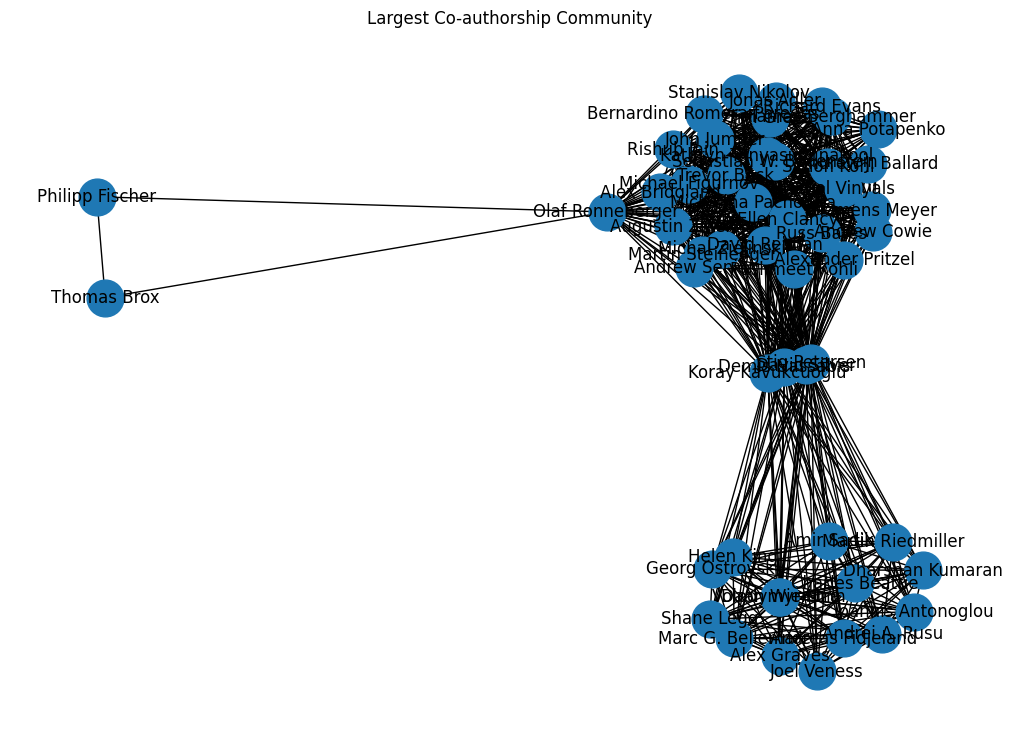

In [17]:
#print out the basic info/stats
print("Number of Nodes (Authors):", G.number_of_nodes())
print("Number of Edges (Collaborations):", G.number_of_edges())

#top 10 most connected authors
degree_centrality = nx.degree_centrality(G)
top_authors = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Authors by Degree Centrality:")
for author, score in top_authors:
    print(f"{author}: {score:.2f}")

#community Detection? (is this how it works?)
from networkx.algorithms import community
communities = community.greedy_modularity_communities(G)
print(f"Number of Communities Detected: {len(communities)}")

#visualize largest community
largest_community = max(communities, key=len)
H = G.subgraph(largest_community)

plt.figure(figsize=(10, 7))
nx.draw(H, pos, with_labels=True, node_size=700)
plt.title("Largest Co-authorship Community")
plt.show()


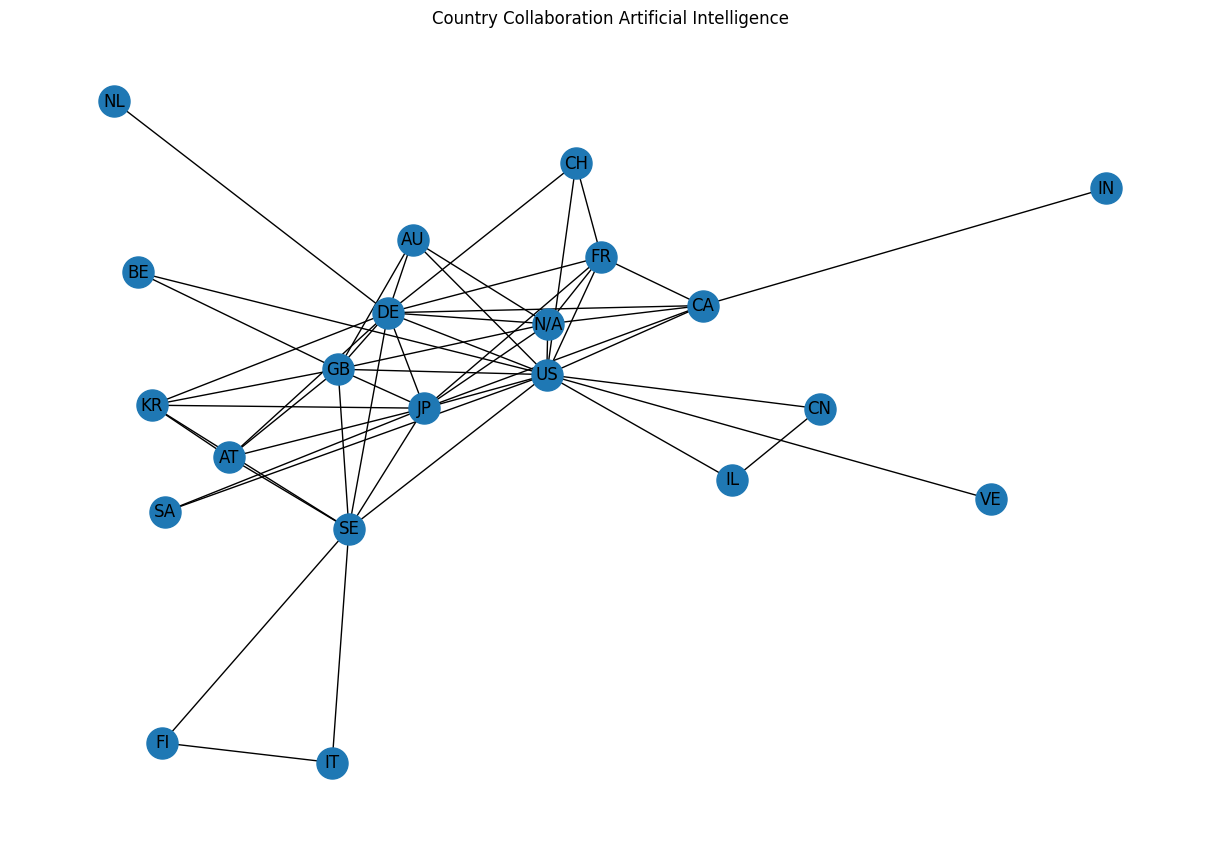

In [19]:
from itertools import combinations
from collections import Counter

country_edges = []

for index, row in df.iterrows():
    countries = list(set(row['Countries'].split(', ')))
    country_edges += list(combinations(countries, 2))

#co-authorships by country
country_pairs = Counter(country_edges)

#attempt at country-level graph
G_country = nx.Graph()

for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

#plot, but unsure how this will look
plt.figure(figsize=(12, 8))
pos_country = nx.spring_layout(G_country, seed=42)
nx.draw(G_country, pos_country, with_labels=True, node_size=500)
plt.title("Country Collaboration Artificial Intelligence")
plt.show()


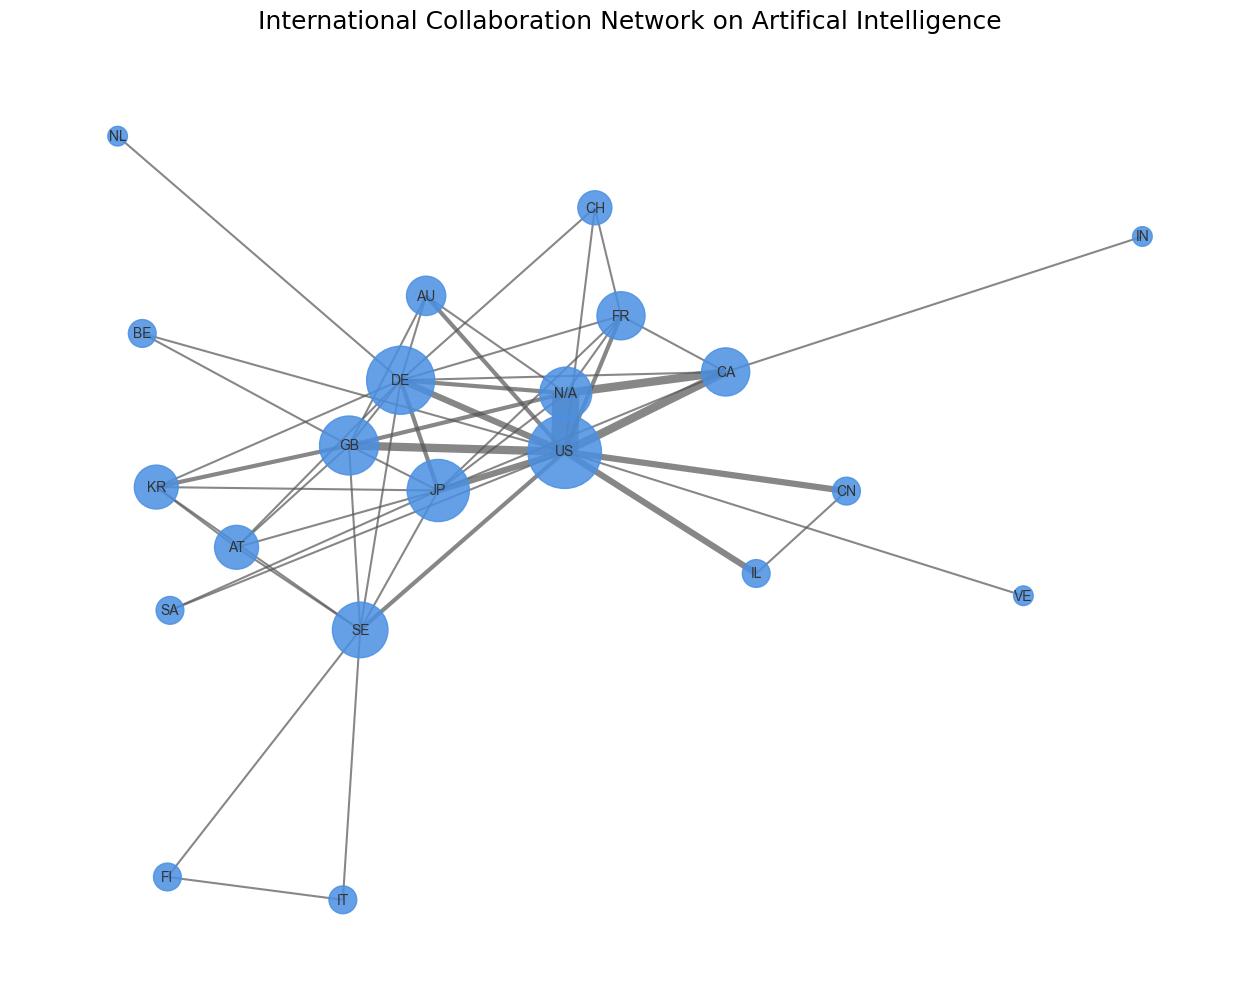

In [21]:
#copy from above
country_edges = []
for index, row in df.iterrows():
    countries = list(set(row['Countries'].split(', ')))
    country_edges += list(combinations(countries, 2))

#copy from above
country_pairs = Counter(country_edges)

#copy from above
G_country = nx.Graph()
for pair, weight in country_pairs.items():
    G_country.add_edge(pair[0], pair[1], weight=weight)

#this and parts below is where I'm caonfused
plt.figure(figsize=(16, 12))
pos_country = nx.spring_layout(G_country, seed=42)

#scale the nodes to make them noticable
node_size = [v * 200 for v in dict(G_country.degree()).values()]

#factor in the weights
edge_width = [d['weight'] * 1.5 for (u, v, d) in G_country.edges(data=True)]

#draw edges. same as before
nx.draw_networkx_edges(G_country, pos_country, width=edge_width, alpha=0.7, edge_color="#555")

#draw nodes. same as before
nx.draw_networkx_nodes(G_country, pos_country, node_size=node_size, node_color="#4a90e2", alpha=0.85)

#draw labels. last attempt didn't work right. remember to play with font size
nx.draw_networkx_labels(G_country, pos_country, font_size=10, font_family="Arial", font_color="#333")

#plt title and display
plt.title("International Collaboration Network on Artifical Intelligence", fontsize=18, pad=20)
plt.axis('off')
plt.show()
